In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC


from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from timeit import default_timer as timer

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
# Upload 2006 dataset
airline_data_2006 = pd.read_csv('airline2006.csv')


In [3]:
# Upload 2007 dataset
#airline_data_2007 = pd.read_csv('airline2007.csv')


In [5]:
# Sample smaller chunks of the 2006 dataset to speed up testing models
half_data_2006 = airline_data_2006.sample(frac=.5, random_state=2, axis=0)
quarter_data_2006 = airline_data_2006.sample(frac=.25, random_state=2, axis=0)
tenth_data_2006 = airline_data_2006.sample(frac=.1, random_state=2, axis=0)
hundreth_data_2006 = airline_data_2006.sample(frac=.01, random_state=2, axis=0)


In [9]:
# create a report function that can be used for any model

def accuracy_report(testing_X, testing_Y, model):
    predictions = model.predict(testing_X)
    print('Model score:')
    print(model.score(testing_X, testing_Y))
    print(" ")
    print('Confusion Matrix (UL: True Negative, UR: False Positive, BL: False Negative, BR: True Positive)')
    print(confusion_matrix(testing_Y.values, predictions))
    print(" ")
    print('Accuracy:')
    print(accuracy_score(testing_Y.values, predictions))
    print(" ")
    print('Recall/Sensitivity (% of late arrivals predicted):')
    print(recall_score(testing_Y.values, predictions))
    print(" ")
    print('Precision (% of on-time arrivals predicted accurately):')
    print(precision_score(testing_Y.values, predictions))
    print(" ")
    auc = roc_auc_score(testing_Y.values, predictions)
    print('AUC score:%.3f'% auc)
    print(" ")
    print('Model cross-valuation:')
#    print(sklearn.model_selection.cross_val_score(model, testing_X, testing_Y, cv = 5))
    return

In [4]:
#working_df.describe()
working_df.head(5)

NameError: name 'working_df' is not defined

#### Variable Descriptions:

1.	Year	1987-2008 
2.	Month	1-12
3.	DayofMonth	1-31
4.	DayOfWeek	1 (Monday) - 7 (Sunday)
5.	DepTime	actual departure time (local, hhmm)
6.	CRSDepTime	scheduled departure time (local, hhmm)
7.	ArrTime	actual arrival time (local, hhmm)
8.	CRSArrTime	scheduled arrival time (local, hhmm)
9.	UniqueCarrier	unique carrier code
10.	FlightNum	flight number
11.	TailNum	plane tail number
12.	ActualElapsedTime	in minutes
13.	CRSElapsedTime	in minutes
14.	AirTime	in minutes
15.	ArrDelay	arrival delay, in minutes
16.	DepDelay	departure delay, in minutes
17.	Origin	origin IATA airport code
18.	Dest	destination IATA airport code
19.	Distance	in miles
20.	TaxiIn	taxi in time, in minutes
21.	TaxiOut	taxi out time in minutes
22.	Cancelled	was the flight cancelled?
23.	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	Diverted	1 = yes, 0 = no
25.	CarrierDelay	in minutes
26.	WeatherDelay	in minutes
27.	NASDelay	in minutes
28.	SecurityDelay	in minutes
29.	LateAircraftDelay	in minutes

In [5]:
# Create a working dataframe so that operations can be performed on any dataframe by switching out a single variable.
working_df = airline_data_2006

# drop cancelation code (column) and any rows where the flight was canceled.
cancelled_flights = working_df.loc[working_df.Cancelled == 1]
working_df = working_df.drop('CancellationCode', axis=1)
working_df = working_df.drop('Cancelled', axis=1)
working_df = working_df.drop(cancelled_flights.index)

# Separate out UniqueCarrier, TailNum, FlightNum, Origin, and Dest 
# to remove non-numeric columns but also keep them available if needed later
working_nonnumeric = working_df[['UniqueCarrier','TailNum','Origin','Dest','FlightNum']]
working_df.drop(['UniqueCarrier','TailNum','Origin','Dest','FlightNum'], axis=1, inplace=True)

# Add in a binary feature for delays of over 30 minutes
working_df.loc[working_df.LateAircraftDelay >= 30, 'AircraftDelayed'] = 1
working_df.loc[working_df.LateAircraftDelay < 30, 'AircraftDelayed'] = 0

# Separate out LateAircraftDelay, TaxiIn, ArrDelay, ActualElapsedTime, ArrTime, and DepDelay, 
# due to them being variables that aren't known before a plane takes off.
cheat_variables = working_df[['LateAircraftDelay',
                              'TaxiIn', 
                              'ArrDelay', 
                              'ActualElapsedTime', 
                              'ArrTime', 
                              'AirTime',
                              'DepDelay']]

working_df.drop(['LateAircraftDelay', 'TaxiIn', 'ArrDelay', 'ActualElapsedTime', 'ArrTime', 'AirTime', 'DepDelay'], 
                axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()

# Reset index so that further additions don't have compatability issues
#working_df = working_df.reset_index(drop=True)
print(" ")

In [6]:
# Cleaning up features, calculating PCA features, and engineering new ones

# drop SecurityDelay, CRSElapsedTime, Distance, DayOfWeek, and Diverted,
# due to them having near-zero correlation with delays
working_df.drop(['SecurityDelay',
                 'CRSElapsedTime',
                 'Distance',
                 'DayOfWeek',
                 'Diverted'], axis=1, inplace=True)

# calculate PCA based on departure and expected arrival times (DepTime, CRSDepTime, CRSArrTime)
departure_arrival = working_df[['DepTime', 'CRSDepTime', 'CRSArrTime']]
pca = PCA(n_components=1)
departure_arrival_PCA = pca.fit_transform(departure_arrival)

# calculate PCA based on delays (DepDelay, TaxiOut, CarrierDelay, WeatherDelay, NASDelay)
delays = working_df[['TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay']]
pca = PCA(n_components=1)
delays_PCA = pca.fit_transform(delays)

# join the PCAs up with the working_df
working_df['departure_arrival_PCA'] = departure_arrival_PCA * -1   
working_df['delays_PCA'] = delays_PCA    

# create new **.5 and **2 features of relevant variables to see which ones have an impact on the models
#working_df['delays_PCA_squared'] = working_df.delays_PCA **2
working_df['delays_PCA_sqrt'] = working_df.delays_PCA **.5
#working_df['departure_PCA_squared'] = departure_arrival_PCA ** 2 
#working_df['departure_PCA_sqrt'] = departure_arrival_PCA ** .5
working_df['departure_discrepancy'] = working_df['DepTime'] - working_df['CRSDepTime']

# drop unmodified versions
working_df.drop(['delays_PCA'], axis=1, inplace=True)

# drop Year, Month, and DayofMonth
working_df.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)

# Drop out any remaining rows with NA in them.
working_df = working_df.dropna()

In [7]:
# create samples for training & testing
training_fraction = .8

training_X = working_df.sample(frac=training_fraction, random_state=10)
testing_X = working_df.drop(training_X.index)

# separate the Class feature out into Y datasets
training_Y = training_X['AircraftDelayed']
testing_Y = testing_X['AircraftDelayed']

# dropping the Class feature from the X datasets so that the model isn't able to cheat
training_X.drop('AircraftDelayed', axis=1, inplace=True)
testing_X.drop('AircraftDelayed', axis=1, inplace=True)
print(" ")

In [8]:
rfc = ensemble.RandomForestClassifier(max_depth = None, max_features = 0.9, n_estimators = 21)
rfc.fit(training_X,training_Y)
print('Random Forest results:')
print(' ')
accuracy_report(testing_X, testing_Y, rfc)

Random Forest results:
 
Model score:
0.9797176914463487
 
Confusion Matrix (UL: True Negative, UR: False Positive, BL: False Negative, BR: True Positive)
[[159133   1566]
 [  2111  18481]]
 
Accuracy:
0.9797176914463487
 
Recall/Sensitivity (% of late arrivals predicted):
0.89748445998446
 
Precision (% of on-time arrivals predicted accurately):
0.9218835736020352
 
AUC score:0.944
 
Model cross-valuation:
[0.97603354 0.97683334 0.976419   0.97716366 0.97572882]


After testing seven different models, Random Forest, Decision Tree, and Gradient Boosting Classifier proved to be the most effective, with Random Forest eaking out a slight lead over DT & GBC.  

Testing with Gridsearch CV revealed a variable optimal parameter space, with the optimum range being around max_features = .9 and n_estimators =21.  

Model could likely be optimized further, given more time and feature engineering, or a more refined model list, but for now an ~%86 correct prediction of delays seems a reasonable result.

In [ ]:
# Decision Tree

dtree = tree.DecisionTreeClassifier(
#    criterion='entropy',
#    max_features=.3,
#    max_depth=4,
)
dtree.fit(training_X,training_Y)
print('Decision Tree results:')
print(' ')
accuracy_report(testing_X, testing_Y, dtree)

In [13]:
# Gradient Boosting Classifier

clf = ensemble.GradientBoostingClassifier(
    n_estimators=300
#    , max_depth=2
    )
clf.fit(training_X,training_Y)
print('Gradient Boosting Classifier results:')
print(' ')
accuracy_report(testing_X, testing_Y, clf)

Gradient Boosting Classifier results:
 
Model score:
0.9577974710904571
 
Confusion Matrix (UL: True Negative, UR: False Positive, BL: False Negative, BR: True Positive)
[[16227   189]
 [  592  1498]]
 
Accuracy:
0.9577974710904571
 
Recall/Sensitivity (% of late arrivals predicted):
0.7167464114832536
 
Precision (% of on-time arrivals predicted accurately):
0.8879668049792531
 
AUC score:0.853
 
Model cross-valuation:
[0.95218801 0.95541745 0.95001351 0.95703864 0.95514726]


In [259]:
# Picking 5 SelectKBest features
X_best = SelectKBest(f_classif, k=5).fit_transform(
    working_df.drop(['AircraftDelayed'], axis=1), 
    working_df['AircraftDelayed'])
X_best_df = pd.DataFrame({
    'best_1':X_best[:,0],
    'best_2':X_best[:,1],
    'best_3':X_best[:,2],
    'best_4':X_best[:,3],
    'best_5':X_best[:,4],
#    'best_6':X_best[:,5],
#    'best_7':X_best[:,6],
#    'best_8':X_best[:,7],
#    'best_9':X_best[:,8],
#    'best_10':X_best[:,9]
})

X_best_df.head(10)

# results for best 5 features = DepTime, CRSDepTime, CRSArrTime, DepDelay, TaxiOut, 


,best_1,best_2,best_3,best_4,best_5
0,1150.000,1135.000,1240.000,-368.837,3.213
1,1508.000,1400.000,1516.000,151.591,2.678
2,1419.000,1252.000,1902.000,228.028,5.163
3,1840.000,1800.000,1925.000,808.584,6.077
4,2309.000,2150.000,26.000,232.697,4.014
5,1034.000,1015.000,1431.000,-400.964,4.355
6,1417.000,1350.000,1615.000,123.565,1.924
7,630.000,621.000,740.000,-1254.543,2.443
8,1939.000,1655.000,1913.000,777.203,3.543
9,1741.000,1700.000,1820.000,633.257,5.140


In [260]:
# Keep:
# DepTime, CRSDepTime, CRSArrTime, CarrierDelay, departure_arrival_PCA, delays_PCA, delays_PCA_sqrt, 
# departure_PCA_squared, departure_PCA_sqrt, departure_discrepancy

# Discard:
# Year, TaxiOut, WeatherDelay, NASDelay, delays_PCA_squared, departure_PCA_squared, departure_PCA_sqrt

#print(travel_distance_PCA)
#working_df.describe()
working_df.head(10)

,DepTime,CRSDepTime,CRSArrTime,CarrierDelay,AircraftDelayed,departure_arrival_PCA,delays_PCA,delays_PCA_sqrt,departure_discrepancy
634606,1150.000,1135,1240,15,0.000,-368.837,10.324,3.213,15.000
6655841,1508.000,1400,1516,0,0.000,151.591,7.171,2.678,108.000
4636729,1419.000,1252,1902,31,1.000,228.028,26.657,5.163,167.000
2549851,1840.000,1800,1925,40,0.000,808.584,36.930,6.077,40.000
239070,2309.000,2150,26,18,1.000,232.697,16.113,4.014,159.000
6957501,1034.000,1015,1431,19,0.000,-400.964,18.967,4.355,19.000
3575508,1417.000,1350,1615,8,0.000,123.565,3.702,1.924,67.000
2070499,630.000,621,740,9,0.000,-1254.543,5.969,2.443,9.000
6826836,1939.000,1655,1913,0,0.000,777.203,12.551,3.543,284.000
6998267,1741.000,1700,1820,31,0.000,633.257,26.418,5.140,41.000


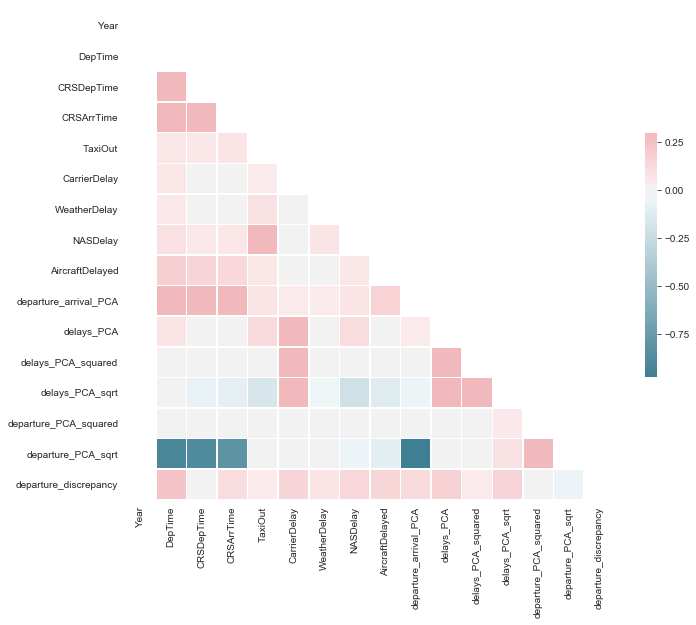

In [222]:
# Compute the correlation matrix
corr = working_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
# Gridsearch CV for the RFC algorithm

grid_param_RFC = {
    'max_features': [.5,.7,.9,'sqrt','log2'],
#    'max_depth': [None,1,2,3,4,5],
    'n_estimators' : [17,18,19,20,21,22]
}

grid_search_RFC = GridSearchCV(estimator = rfc,  
                              param_grid = grid_param_RFC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_RFC.fit(testing_X, testing_Y)
print('RFC recommended parameters:')
print(grid_search_RFC.best_params_)
print(' ')

RFC recommended parameters:
{'max_features': 0.9, 'n_estimators': 22}
 


{'max_depth': None, 'max_features': 0.7, 'n_estimators': 15}
{'max_depth': None, 'max_features': 0.9, 'n_estimators': 21}
{'max_depth': None, 'max_features': 0.7, 'n_estimators': 19}
{'max_features': 0.9, 'n_estimators': 22}



In [45]:
# Gridsearch CV for the KNN algorithm

grid_param_KNN = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'n_neighbors' : [1,2,3,4,5,6,7]
}

grid_search_KNN = GridSearchCV(estimator = neighbors,  
                              param_grid = grid_param_KNN,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_KNN.fit(testing_X, testing_Y)
print('KNN recommended parameters:')
print(grid_search_KNN.best_params_)
print(' ')

KNN recommended parameters:
{'algorithm': 'ball_tree', 'n_neighbors': 6, 'weights': 'uniform'}
 


In [54]:
# Gridsearch CV for the RFC algorithm

grid_param_RFC = {
    'max_features': [.1,.3,.5,.7,.9,'sqrt','log2'],
    'max_depth': [None,1,2,3,4,5],
    'n_estimators' : [2,5,8,9,10,11,12,15,18,20]
}

grid_search_RFC = GridSearchCV(estimator = rfc,  
                              param_grid = grid_param_RFC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_RFC.fit(testing_X, testing_Y)
print('KNN recommended parameters:')
print(grid_search_RFC.best_params_)
print(' ')

KNN recommended parameters:
{'max_depth': None, 'max_features': 0.3, 'n_estimators': 5}
 


In [60]:
# Gridsearch CV for the Logistic Regression algorithm

grid_param_LR = {
    'penalty': ['l1', 'l2'],
    'C': [1,.1,.3,.5,.7,.9]
#   , 'solver' : ['liblinear','saga']
# Repeated warnings about iter limits being exceeded resulted from including the previous line in the code
}

grid_search_LR = GridSearchCV(estimator = lr,  
                              param_grid = grid_param_LR,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_LR.fit(testing_X, testing_Y)
print('Logistic Regression recommended parameters:')
print(grid_search_LR.best_params_)
print(' ')

Logistic Regression recommended parameters:
{'C': 0.9, 'penalty': 'l1'}
 


In [ ]:
# Gridsearch CV for the Gradient Boosting Classifier algorithm

grid_param_GBC = {
    'n_estimators': [100,75,150,200,300],
    'learning_rate': [.1,.08,.06,.12,.14], 
    'criterion' : ['friedman_mse','mse','mae'],
    'max_depth': [1,2,3,4,5,6]
}

grid_search_GBC = GridSearchCV(estimator = clf,  
                              param_grid = grid_param_GBC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_GBC.fit(testing_X, testing_Y)
print('Gradient Boosting Classifier recommended parameters:')
print(grid_search_GBC.best_params_)
print(' ')

Decision Tree Model score:
0.9419647681832919
Decision Tree Model cross-valuation:
[0.93814155 0.93191029 0.93082951 0.93488246 0.93082951]


Decision Tree Model Classification Report:
 
Confusion Matrix (UL: True Negative, UR: False Positive, BL: False Negative, BR: True Positive)
[[15862   554]
 [  520  1570]]
 
Accuracy:
0.9419647681832919
 
Recall/Sensitivity (% of late arrivals predicted):
0.7511961722488039
 
Precision (% of on-time arrivals predicted accurately):
0.7391713747645952
 
AUC score:0.859


Ensemble models, either Random Forest or Gradient Boosting Classifier, provide near-perfect (100%, in most folds) accuracy within the bounds of the dataset provided, as did L1 Logistic Regression.  All other algorithms result in unacceptably high false negative results.  

